In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np


In [5]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

trainset = datasets.FashionMNIST('data_original/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data_original/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [20]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [15]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

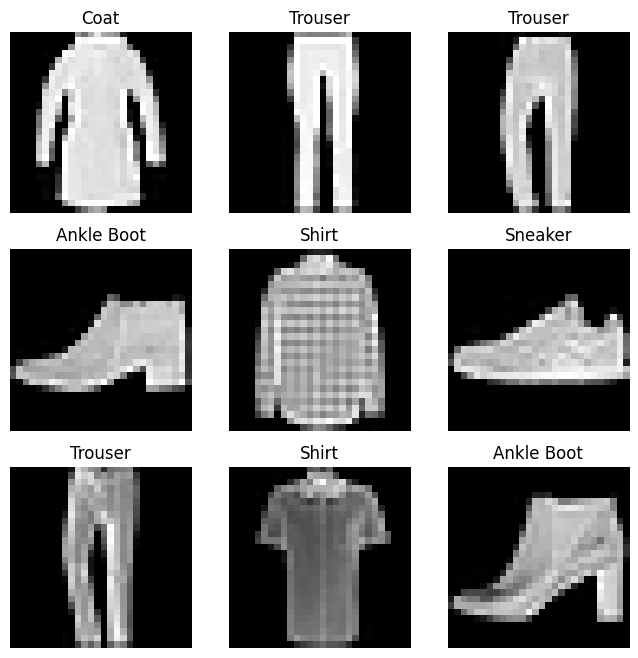

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [55]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        print(f"{x.shape=}")
        
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        print(f"{h=}")
        print(f"{w=}")
        print(f"{offset.shape=}")
        print(f"{modulator.shape=}")
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator
                                          )
        print(f"{x.shape=}")
        return x
     

In [56]:
x, label = trainset[0]

In [57]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 deformable=False):

        super(MNISTClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)   
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [58]:
earlystopper_deform = EarlyStopper(min_delta = 0, patience =3)

model_deform = MNISTClassifier(deformable=True)

model_deform.to(device)

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv5): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_feat

In [59]:
batch1 = next(iter(trainloader))
X, y = batch1
model_deform(X)

x.shape=torch.Size([32, 32, 7, 7])
h=7
w=7
offset.shape=torch.Size([32, 18, 7, 7])
modulator.shape=torch.Size([32, 9, 7, 7])
x.shape=torch.Size([32, 32, 7, 7])
x.shape=torch.Size([32, 32, 7, 7])
h=7
w=7
offset.shape=torch.Size([32, 18, 7, 7])
modulator.shape=torch.Size([32, 9, 7, 7])
x.shape=torch.Size([32, 32, 7, 7])


tensor([[-0.0900,  0.1468,  0.1454,  0.0487, -0.1639,  0.0714, -0.0434,  0.1771,
          0.0213,  0.0847],
        [-0.0891,  0.1480,  0.1472,  0.0482, -0.1626,  0.0719, -0.0427,  0.1761,
          0.0223,  0.0854],
        [-0.0891,  0.1475,  0.1464,  0.0486, -0.1635,  0.0711, -0.0431,  0.1766,
          0.0215,  0.0845],
        [-0.0893,  0.1474,  0.1463,  0.0487, -0.1632,  0.0714, -0.0429,  0.1766,
          0.0219,  0.0848],
        [-0.0882,  0.1486,  0.1480,  0.0480, -0.1621,  0.0721, -0.0427,  0.1759,
          0.0228,  0.0861],
        [-0.0901,  0.1469,  0.1456,  0.0488, -0.1639,  0.0713, -0.0432,  0.1772,
          0.0210,  0.0843],
        [-0.0907,  0.1466,  0.1451,  0.0485, -0.1644,  0.0716, -0.0436,  0.1776,
          0.0208,  0.0847],
        [-0.0901,  0.1469,  0.1456,  0.0486, -0.1639,  0.0714, -0.0433,  0.1766,
          0.0212,  0.0848],
        [-0.0892,  0.1474,  0.1462,  0.0486, -0.1634,  0.0712, -0.0428,  0.1767,
          0.0218,  0.0846],
        [-0.0895,  

In [12]:
deform_batch_tr_loss = {}
deform_batch_te_loss = {}

deform_best_test_loss = float('inf')

loss_fn_deform = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform.parameters(), lr=0.001)

# epoch loss and accuracy
tr_loss_deform, tr_acc_deform = [], []
te_loss_deform, te_acc_deform = [], []

for t in (range(NUM_OF_EPOCHS)):
    model_deform.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = model_deform(X)
        loss = loss_fn_deform(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss_deform.append(sum(batch_loss)/batches)
    tr_acc_deform.append(sum(batch_accuracy)/batches)

    model_deform.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = model_deform(X)
            loss = loss_fn_deform(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss_deform.append(sum(batch_loss)/batches)
        te_acc_deform.append(sum(batch_accuracy)/batches)

    # Save the model_deform's weights after each epoch
    torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_model_deform_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss_deform[-1] < deform_best_test_loss:
        deform_best_test_loss = te_loss_deform[-1]
        # Save the model_deform's weights with the best test loss
        torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_best_model_deform_weights.pth")

    if earlystopper_deform.early_stop(te_loss_deform[-1]):
      print(f"Early Stop at {t+1} epochs.")
      print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")
      break

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")


Epoch 1 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.28it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.50it/s] 


Epoch 1: Train_accuracy: 76.01%, Train_loss: 0.636468, Test_accuracy: 83.16%, Test_loss: 0.452367
Epoch 2 Training...


100%|██████████| 1875/1875 [00:14<00:00, 133.79it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:03<00:00, 81.20it/s] 


Epoch 2: Train_accuracy: 85.78%, Train_loss: 0.392439, Test_accuracy: 85.65%, Test_loss: 0.395833
Epoch 3 Training...


100%|██████████| 1875/1875 [00:13<00:00, 138.97it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.03it/s] 


Epoch 3: Train_accuracy: 87.96%, Train_loss: 0.329225, Test_accuracy: 87.63%, Test_loss: 0.339805
Epoch 4 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.20it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.08it/s] 


Epoch 4: Train_accuracy: 89.19%, Train_loss: 0.292606, Test_accuracy: 88.73%, Test_loss: 0.308494
Epoch 5 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.15it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.96it/s] 


Epoch 5: Train_accuracy: 90.33%, Train_loss: 0.265484, Test_accuracy: 89.56%, Test_loss: 0.287117
Epoch 6 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.25it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.69it/s] 


Epoch 6: Train_accuracy: 91.03%, Train_loss: 0.244946, Test_accuracy: 90.56%, Test_loss: 0.262909
Epoch 7 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.99it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.35it/s] 


Epoch 7: Train_accuracy: 91.56%, Train_loss: 0.232271, Test_accuracy: 90.26%, Test_loss: 0.266766
Epoch 8 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.05it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.33it/s] 


Epoch 8: Train_accuracy: 92.08%, Train_loss: 0.219498, Test_accuracy: 90.10%, Test_loss: 0.276293
Epoch 9 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.44it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.19it/s] 


Epoch 9: Train_accuracy: 92.45%, Train_loss: 0.205631, Test_accuracy: 91.20%, Test_loss: 0.247574
Epoch 10 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.04it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.94it/s] 


Epoch 10: Train_accuracy: 92.65%, Train_loss: 0.197590, Test_accuracy: 90.92%, Test_loss: 0.254218
Epoch 11 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.42it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.84it/s] 


Epoch 11: Train_accuracy: 93.07%, Train_loss: 0.188882, Test_accuracy: 91.45%, Test_loss: 0.235024
Epoch 12 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.38it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.06it/s] 


Epoch 12: Train_accuracy: 93.47%, Train_loss: 0.181449, Test_accuracy: 90.76%, Test_loss: 0.253607
Epoch 13 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.24it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.85it/s] 


Epoch 13: Train_accuracy: 93.45%, Train_loss: 0.175501, Test_accuracy: 91.50%, Test_loss: 0.239679
Epoch 14 Training...


100%|██████████| 1875/1875 [00:14<00:00, 133.15it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.79it/s] 

Early Stop at 14 epochs.
Epoch 14: Train_accuracy: 93.75%, Train_loss: 0.169051, Test_accuracy: 91.41%, Test_loss: 0.247076
